In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transforms3d.euler import euler2mat
import colorsys

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

# Введение

Продолжим работать с усеченной пирамидой с предыдущей практики:

In [2]:
VERTICES_GT = np.array([
    [-1.5, 1, -1.5],
    [1.5, 1, -1.5],
    [1.5, 1, 1.5],
    [-1.5, 1, 1.5],
    [-1, -1, -1],
    [1, -1, -1],
    [1, -1, 1],
    [-1, -1, 1]
])

EPS = 1e-5

Ширина и высота кадра, а также матрица проекции камеры `PROJ_MAT` $3\times3$,
которые будем использовать для отрисовки изображений:

In [4]:
IMG_WIDTH = 800
IMG_HEIGHT = 600

fx = fy = 400
cx = IMG_WIDTH / 2
cy = IMG_HEIGHT / 2

PROJ_MAT = np.array([
    [fx, 0, cx, 0],
    [0, fy, cy, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

Также воспользуемся вспомогательными функциями:

In [5]:
def generate_colors(count):
    hues = np.linspace(0, 1, count, endpoint=False)
    colors = []
    for h in hues:
        colors.append(colorsys.hsv_to_rgb(h, 1, 1))
    return colors


VERTICES_COLORS = generate_colors(len(VERTICES_GT))

def draw_pyramid(points2d, edge_color=(0, 1, 0), vertices_colors=VERTICES_COLORS):
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
    int_tuples = [tuple(map(int, p)) for p in points2d]
    point_size = 5
    edge_thickness = 2
    edges = [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 4],
        [0, 4],
        [1, 5],
        [2, 6],
        [3, 7]
    ]
    for i, j in edges:
        u = int_tuples[i]
        v = int_tuples[j]
        cv2.line(img, u, v, edge_color, edge_thickness)
    for u, color in zip(int_tuples, vertices_colors):
        cv2.circle(img, u, point_size, color, -1)
    return img

def project_points3d(points3d, pmat):
    points4d = np.hstack((
        points3d,
        np.ones((points3d.shape[0], 1))
    ))
    points4d = (pmat @ points4d.T).T
    points4d /= points4d[:, 3].reshape(-1, 1)
    return points4d[:, :2]

def rmat_and_tvec_to_mat4x4(rmat, tvec):
    mat = np.eye(4)
    mat[:3, :3] = rmat
    mat[:3, 3] = tvec
    return mat

def camera_pose_4x4_to_view_mat(pose):
    return np.linalg.inv(pose)

def point_to_homogeneous(point):
    return np.append(point, 1.0)

# Задание 1

1. Напишите функцию `compute_epipole_from_poses`, которая находит эпиполь на изображении камеры с позицией `camera_pos_1`, соответствующую позиции камеры `camera_pos_2`.
2. Напишите функцию `draw_epipole` для отрисовки эпиполи с использованием функции `cv2.circle`.
3. Поэкспериментируйте с различными позициями пары камер и посмотрите, куда будут перемещаться эпиполи на изображениях.

In [82]:
def compute_epipole_from_poses(camera_pos_1, camera_pos_2, proj_mat):
    P1 = proj_mat @ camera_pose_4x4_to_view_mat(camera_pos_1)
    point3d = camera_pos_2[:3, 3]
    point4d = point_to_homogeneous(point3d)
    res = np.dot(P1, point4d)
    if res[-1] != 0:
        res /= res[-1]
    return res[[0, 1, 3]]

def draw_epipole(image, epipole, radius=5, color=(1, 1, 1)):
    if epipole[-1] != 0:
        pos = (epipole[:2] / epipole[-1]).astype(int)
        cv2.circle(image, pos, radius, color)
    return image

Рассмотрим пару изображений пирамиды, снятых на камеру в позициях `camera_pose_1` и `camera_pose_2`. Посчитаем эпиполи:

In [112]:
camera_pose_1 = rmat_and_tvec_to_mat4x4(
    euler2mat(0, 0, 0),
    np.array([0, 0, -5]))
view_proj_1 = PROJ_MAT @ camera_pose_4x4_to_view_mat(camera_pose_1)
points2d_1 = project_points3d(VERTICES_GT, view_proj_1)
img_1 = draw_pyramid(points2d_1)

camera_pose_2 = rmat_and_tvec_to_mat4x4(
    euler2mat(0, np.deg2rad(65.0), 0),
    np.array([-4, 0, -5]))
view_proj_2 = PROJ_MAT @ camera_pose_4x4_to_view_mat(camera_pose_2)
points2d_2 = project_points3d(VERTICES_GT, view_proj_2)
img_2 = draw_pyramid(points2d_2)


epipole_1 = compute_epipole_from_poses(camera_pose_1, camera_pose_2, PROJ_MAT)
epipole_2 = compute_epipole_from_poses(camera_pose_2, camera_pose_1, PROJ_MAT)
assert np.linalg.norm(epipole_1 - np.array([-1600.0, 0.0, 0.0])) < EPS
assert np.linalg.norm(epipole_2 - np.array([586.52306326, 300.0, 1.0])) < EPS

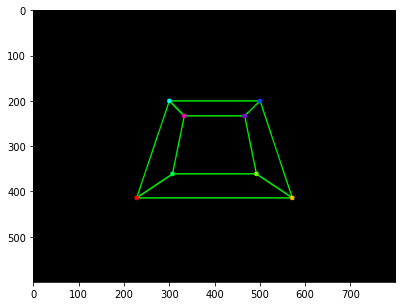

In [90]:
plt.imshow(draw_epipole(img_1, epipole_1))

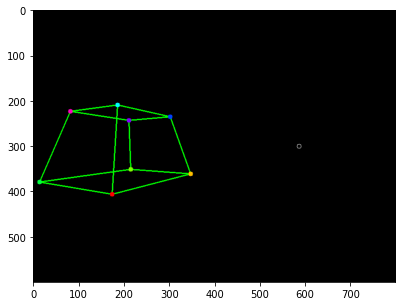

In [91]:
plt.imshow(draw_epipole(img_2, epipole_2))

In [115]:
camera_pose_1 = rmat_and_tvec_to_mat4x4(
    euler2mat(0, 0, 0),
    np.array([0, 0, -5]))
view_proj_1 = PROJ_MAT @ camera_pose_4x4_to_view_mat(camera_pose_1)
points2d_1 = project_points3d(VERTICES_GT, view_proj_1)
img_1 = draw_pyramid(points2d_1)

camera_pose_2 = rmat_and_tvec_to_mat4x4(
    euler2mat(0, 0, 0),
    np.array([0, 0, -7]))
view_proj_2 = PROJ_MAT @ camera_pose_4x4_to_view_mat(camera_pose_2)
points2d_2 = project_points3d(VERTICES_GT, view_proj_2)
img_2 = draw_pyramid(points2d_2)
epipole_1 = compute_epipole_from_poses(camera_pose_1, camera_pose_2, PROJ_MAT)
epipole_2 = compute_epipole_from_poses(camera_pose_2, camera_pose_1, PROJ_MAT)

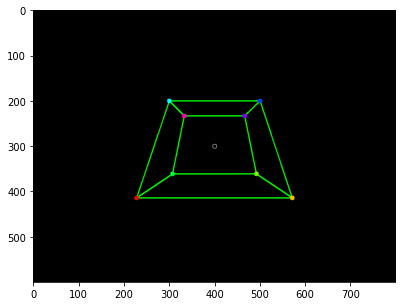

In [116]:
plt.imshow(draw_epipole(img_1, epipole_1))

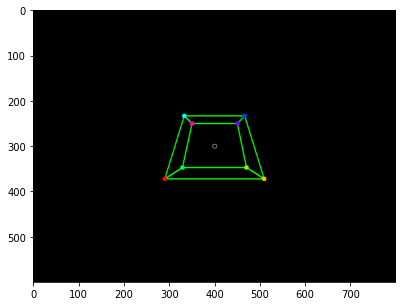

In [117]:
plt.imshow(draw_epipole(img_2, epipole_2))

# Задание 2
1. Напишите функцию `compute_epipolar_line_from_poses`, которая вычисляет эпиполярную линию на изображении первой камеры с позицией `camera_pos_1`, соответствующую точке `pnt2d_camera2` на изображении второй камеры с позицией `camera_pos_2`.
Результатом функции должен быть кортеж (a, b, c) с коэффициентам уравнения этой линии $ax + by + c = 0$.
2. Напишите функцию для отрисовки эпиполярных линий для набора точек `draw_epipolar_lines` с использованием функции `cv2.line`. Нарисуйте эпиполярные линии для уголков пирамиды.
3. Поэкспериментируйте с различными позициями пары камер и посмотрите, куда будут перемещаться эпиполярные линии и эпиполи на изображениях.

In [118]:
def build_vec_prod(point3d):
    return np.array([
        [0, -point3d[2], 0, point3d[1]],
        [point3d[2], 0, 0, -point3d[0]],
        [0, 0, 0, 0],
        [-point3d[1], point3d[0], 0, 0],
    ])

def compute_epipolar_line_from_poses(camera_pos_1, camera_pos_2,
                                     pnt2d_camera2, proj_mat):
    P1 = proj_mat @ camera_pose_4x4_to_view_mat(camera_pos_1)
    P2 = proj_mat @ camera_pose_4x4_to_view_mat(camera_pos_2)
    e1 = compute_epipole_from_poses(camera_pos_1, camera_pos_2, proj_mat)
    e1_vp = build_vec_prod(e1)
    F = e1_vp @ P1 @ np.linalg.inv(P2)
    pnt = np.append(pnt2d_camera2, [0, 1])
    return np.dot(F, pnt)[[0, 1, 3]]

def get_points(line):
    if line[0] != 0:
        a = [-line[2] / line[0], 0]
        b = [-(line[1] * IMG_HEIGHT + line[2]) / line[0], IMG_HEIGHT]
    else:
        a = [0, -line[2] / line[1]]
        b = [IMG_WIDTH, -(line[0] * IMG_WIDTH + line[2]) / line[1]]
    return np.array(a), np.array(b)

def draw_epipolar_lines(image, lines):
    for line in lines:
        p, q = get_points(line)
        cv2.line(image, p.astype(int), q.astype(int), (1, 1, 1))
    return image

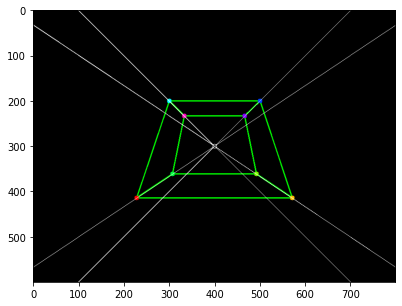

In [119]:
epipolar_lines_img_1 = [compute_epipolar_line_from_poses(
    camera_pose_1, camera_pose_2, pt, PROJ_MAT) for pt in points2d_2]
plt.imshow(draw_epipole(draw_epipolar_lines(
    draw_pyramid(points2d_1), epipolar_lines_img_1), epipole_1))

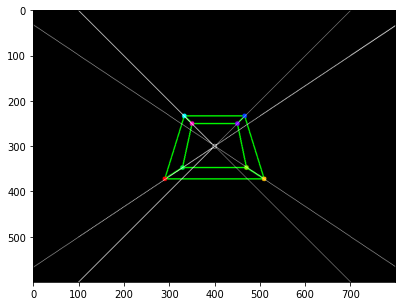

In [120]:
epipolar_lines_img_2 = [compute_epipolar_line_from_poses(
    camera_pose_2, camera_pose_1, pt, PROJ_MAT) for pt in points2d_1]
plt.imshow(draw_epipole(draw_epipolar_lines(
    draw_pyramid(points2d_2), epipolar_lines_img_2), epipole_2))

# Задание 3
1. Напишите функцию `compute_fundamental_mat_from_poses` для вычисления фундаментальной матрицы по известным позициям камеры `camera_pos_1` и `camera_pos_2`.
2. Напишите функции `compute_epipole` и `compute_epipolar_line` для вычисления эпиполей и эпиполярных линий из фунднаментальной матрицы. Для этого воспользуйтесь свойствами фундаментальной матрицы.

In [27]:
def compute_fundamental_mat_from_poses(camera_pose_1, camera_pose_2, proj_mat):
    pass # TODO implement

def compute_epipole(f_mat):
    pass # TODO implement

def compute_epipolar_line(f_mat, point2d):
    pass # TODO implement

In [ ]:
f_mat1 = compute_fundamental_mat_from_poses(camera_pose_1, camera_pose_2, PROJ_MAT)
epipolar_lines_img_1 = [compute_epipolar_line(f_mat1, pt) for pt in points2d_2]
epipole_img_1 = compute_epipole(f_mat1.T)
plt.imshow(draw_epipole(draw_epipolar_lines(
    draw_pyramid(points2d_1), epipolar_lines_img_1), epipole_img_1))

In [ ]:
f_mat2 = compute_fundamental_mat_from_poses(camera_pose_2, camera_pose_1, PROJ_MAT)
epipolar_lines_img_2 = [compute_epipolar_line(f_mat2, pt) for pt in points2d_1]
epipole_img_2 = compute_epipole(f_mat2.T)
plt.imshow(draw_epipole(draw_epipolar_lines(
    draw_pyramid(points2d_2), epipolar_lines_img_2), epipole_img_2))

# Задание 4*
1. Напишите функцию `compute_fundamental_mat` для вычисления фундаментальной матрицы по двумерным соответствиям `pnts2d_1` и `pnts2d_2`, используя уравнение эпиполярного ограничения.
2. Сгенерируйте набор пар позиций камер, соответствующих различным относительным движениям между камерами: только параллельный перенос, только вращение, параллельный перенос вдоль плоскости камеры, параллельный перенос вдоль оси $Z$ камеры и т.п..
3. Для полученных пар сгенерируйте изображения пирамиды и посчитайте фундаментальную матрицу на основе спроецированных уголков пирамиды.
4. Посчитайте и нарисуйте эпиполи и эпиполярные линии для полученных фундаментальных матриц.

In [26]:
def compute_fundamental_mat(pnts2d_1, pnts2d_2):
    pass # TODO implement


# Задание 5*
1. Добавьте шум к спроецированным уголкам пирамиды из предыдущего задания с помощью функции `add_noize_to_points` и посчитайте фундаментальные матрицы на полученных двумерных соответствиях.
2. Посчитайте и нарисуйте эпиполи и эпиполярные линии для полученных фундаментальных матриц. Что с ними не так?
3. Попробуйте предложить способ для исправления возникшей проблемы.

In [27]:
def add_noize_to_points(points, noise_scale):
    return points + np.random.normal(scale=noise_scale, size=points.shape)